In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from simulations.utils import spearman, pearson
from simulations.utils.generalized_jaccard import get_positive_part, get_negative_part

from scipy.stats import rankdata

In [3]:
from plot_utils.reflected_kde import initialize_reflected_kde
from plot_utils import cool_savefig

In [4]:
initialize_reflected_kde((-1,1))

In [5]:
number_simulations = 1000
entropy = 42
seed = np.random.SeedSequence(entropy)

In [6]:
def get_matrix(rng):
    """
    We are only interested in Beta distributions with same concentration parameter as uniform,
    that is the same value of concentration as Beta(2*0.5, 2*0.5) = Uniform(0,1)
    """
    hyperparameter = rng.random()
    random_numbers = rng.beta(a=2.*(hyperparameter), b=2.*(1.-hyperparameter),
                             size=(100,100))
    base_random_network = 2. * (random_numbers - 0.5)
    random_mask = rng.integers(low=0, high=2, size=(100,100)).astype(float)
    result = base_random_network * random_mask
    return result

def get_matrix_pair(rng):
    matrix1 = get_matrix(rng)
    matrix2 = get_matrix(rng)
    return (matrix1, matrix2)

In [7]:
def get_common_relevant_indices(matrix1, matrix2):
    """
    Basically the analogue of `np.nonzero` where the criterion is relaxed 
    to entry being nonzero in at least one of the two.
    """
    return np.nonzero(np.logical_or((matrix1 != 0), (matrix2 != 0)))

def get_common_relevant_entries(matrix1, matrix2):
    relevant_indices = get_common_relevant_indices(matrix1, matrix2)
    entries1 = matrix1[relevant_indices]
    entries2 = matrix2[relevant_indices]
    return entries1, entries2

In [8]:
def mixed_sign_spearman(matrix1, matrix2):
    entries1, entries2 = get_common_relevant_entries(matrix1, matrix2)
    # do it this way instead of applying get_common_relevant_indices
    # to positive and negative parts separately so that theory/guarantees
    # still hold and interpretation is easier -- not sure if important practical difference
    
    pos_entries1 = get_positive_part(entries1)
    pos_entries2 = get_positive_part(entries2)
    
    neg_entries1 = get_negative_part(entries1)
    neg_entries2 = get_negative_part(entries2)
    
    # does mean pos. and neg. spearman will still be adding some credit for "true negatives" in general
    # but they were already doing that on a much worse/larger scale anyway so it's probably fine...
    
    rank_vectors1 = [rankdata(pos_entries1), rankdata(neg_entries1)]
    rank_vectors2 = [rankdata(pos_entries2), rankdata(neg_entries2)]
    
    return pearson(np.concatenate(rank_vectors1), np.concatenate(rank_vectors2))

def pos_spearman(matrix1, matrix2):
    entries1, entries2 = get_common_relevant_entries(matrix1, matrix2)
    
    pos_entries1 = get_positive_part(entries1)
    pos_entries2 = get_positive_part(entries2)
    
    return spearman(pos_entries1, pos_entries2)

def neg_spearman(matrix1, matrix2):
    entries1, entries2 = get_common_relevant_entries(matrix1, matrix2)
    
    neg_entries1 = get_negative_part(entries1)
    neg_entries2 = get_negative_part(entries2)
    
    return spearman(neg_entries1, neg_entries2)

def raw_spearman(matrix1, matrix2):
    entries1, entries2 = get_common_relevant_entries(matrix1, matrix2)
    return spearman(entries1, entries2)

def mag_spearman(matrix1, matrix2): 
    entries1, entries2 = get_common_relevant_entries(matrix1, matrix2)
    return spearman(np.abs(entries1), np.abs(entries2))

def sign_spearman(matrix1, matrix2): 
    entries1, entries2 = get_common_relevant_entries(matrix1, matrix2)
    return spearman(np.sign(entries1), np.sign(entries2)) 

In [9]:
def more_pos_than_neg(matrix):
    num_pos = np.sum(matrix > 0)
    num_neg = np.sum(matrix < 0)
    
    return num_pos > num_neg

# The idea here is to ignore at least for now those matrices with num_pos == num_neg

def more_neg_than_pos(matrix):
    num_pos = np.sum(matrix > 0)
    num_neg = np.sum(matrix < 0)
    
    return num_neg > num_pos

In [10]:
def crest(index): return sns.color_palette("crest", 10)[index]

def plot_attack(random_matrices, attack_function, title='Attack',
                variants=["dom_spearman", "sub_spearman", "mixed_sign_spearman",
                         "raw_spearman", "mag_spearman", "sign_spearman"], **plot_kwargs):
    
    attacked_matrices = [(matrix, attack_function(matrix)) for matrix in random_matrices]
    pos_dom_attackeds = [pair for pair in attacked_matrices if more_pos_than_neg(pair[0])]
    neg_dom_attackeds = [pair for pair in attacked_matrices if more_neg_than_pos(pair[0])]
    attacked_matrices = pos_dom_attackeds + neg_dom_attackeds
    
    spearman_values = {
    "dom_spearman": np.asarray([pos_spearman(*pair) for pair in pos_dom_attackeds] +
                              [neg_spearman(*pair) for pair in neg_dom_attackeds]),
    "sub_spearman": np.asarray([neg_spearman(*pair) for pair in pos_dom_attackeds] +
                              [pos_spearman(*pair) for pair in neg_dom_attackeds]),
    "mixed_sign_spearman": np.asarray([mixed_sign_spearman(*pair) for pair in attacked_matrices]),
    # round to within .05, because no one cares about difference between .9999999 and 1, but it still
    # messes up Seaborn violinplots -- makes super-wide KDE instead of treating all as one value
    "raw_spearman": np.asarray([np.round(20*raw_spearman(*pair))/20 for pair in attacked_matrices]),
    "mag_spearman": np.asarray([mag_spearman(*pair) for pair in attacked_matrices]),
    "sign_spearman": np.asarray([sign_spearman(*pair) for pair in attacked_matrices]),
    }
    spearman_values_matrix = np.concatenate([spearman_values[variant].reshape((-1,1)) 
                                             for variant in variants], axis=1)
    
    color_map = {"dom_spearman": crest(0), "mixed_sign_spearman": crest(2), "sub_spearman": crest(4),
                "raw_spearman": crest(7), "mag_spearman": crest(5), "sign_spearman": crest(9)}
    
    variant_titles = {"dom_spearman": "Dominant Sign Edges", "mixed_sign_spearman": "Mixed-Sign Spearman",
                     "sub_spearman": "Submissive Sign Edges", "raw_spearman": "Raw", 
                     "mag_spearman": "Magnitudes Only", "sign_spearman": "Signs Only"}
    
    with sns.axes_style("darkgrid"):
        plt.figure(figsize=(12,8))
        ax = sns.violinplot(data=spearman_values_matrix, cut=0, 
                            palette=[color_map[variant] for variant in variants], **plot_kwargs)
        ax.set_xticklabels([variant_titles[variant] for variant in variants], fontsize=14)
        ax.set_ylim((-1.05,1.05))
        ax.set_ylabel('Value', fontsize=18)
        ax.set_title(title, fontsize=24)
        cool_savefig(title)
    
def plot_attack_conv_comb(random_matrices, attack_function, title='Attack', **plot_kwargs):
    plot_attack(random_matrices, attack_function, title=title,
               variants=["dom_spearman", "mixed_sign_spearman", "sub_spearman"], **plot_kwargs)
    
def plot_attack_alts(random_matrices, attack_function, title='Attack', **plot_kwargs):
    plot_attack(random_matrices, attack_function, title=title, 
               variants=["mixed_sign_spearman", "raw_spearman", "mag_spearman", "sign_spearman"], 
                **plot_kwargs)

In [11]:
%%time
rng = np.random.default_rng(seed)
random_matrices = [get_matrix(rng) for simulation in range(number_simulations)]

CPU times: user 4.09 s, sys: 78.6 ms, total: 4.17 s
Wall time: 4.24 s


## Shift Attack

For a positive dominated matrix, if we shift all of the entries by a constant such that they are all negative, most of them will have their magnitudes disrupted. In particular this will mess up the relative ordering of the magnitudes substantially. However raw spearman will be oblivious.

The attack proceeds similarly for a negative dominated matrix. All entries now become positive.

In [12]:
def shift_attack(matrix):
    num_neg = np.sum(matrix < 0.)
    num_pos = np.sum(matrix > 0.)
    
    result = matrix.copy()
    
    if num_neg > num_pos:
        result[np.nonzero(matrix)] += 2.*np.abs(np.min(matrix, axis=None))
    if num_pos > num_neg:
        result[np.nonzero(matrix)] -= 2.*np.max(matrix, axis=None)
        
    return result

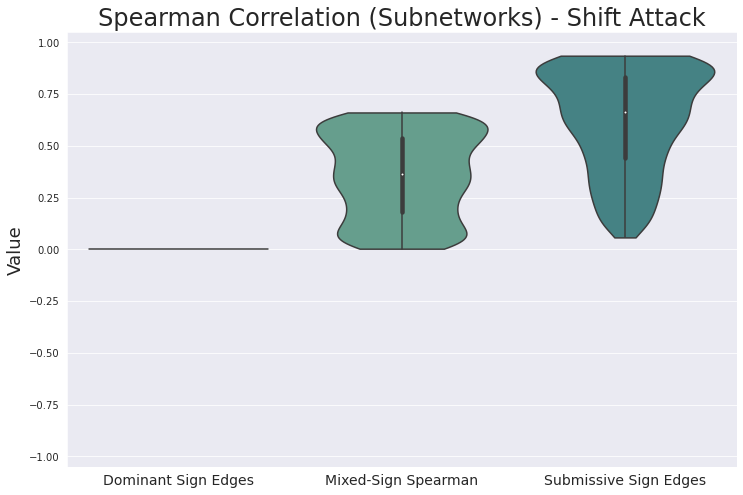

In [13]:
plot_attack_conv_comb(random_matrices, shift_attack, title='Spearman Correlation (Subnetworks) - Shift Attack')

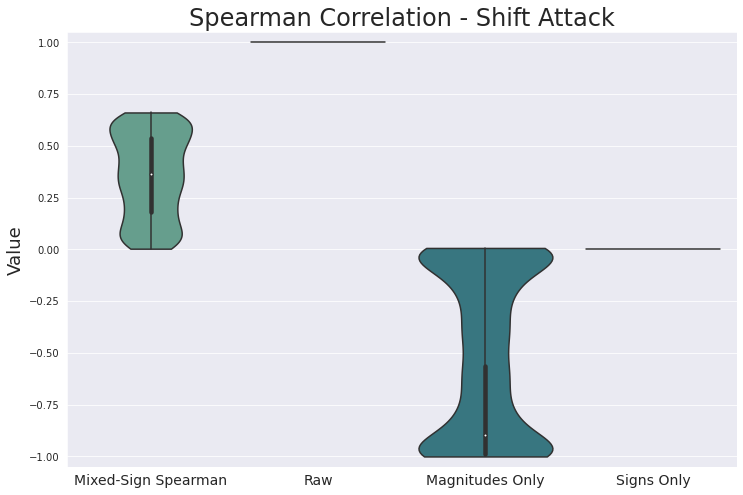

In [14]:
plot_attack_alts(random_matrices, shift_attack, title='Spearman Correlation - Shift Attack')

## Magnitude Swap Attack

Replace $n$'th largest entry of matrix (in terms of absolute value) with $n$'th smallest for all $n$ (same also as replacing $n$'th smallest with $n$'th largest for all $n$), while leaving the signs exactly the same.

In [15]:
def magnitude_attack(matrix):
    nonzero_indices = np.nonzero(matrix)
    nonzero_entries = matrix[nonzero_indices]
    
    signs = np.sign(nonzero_entries)
    magnitudes = np.abs(nonzero_entries)
    
    # note how/why (np.sort(vector))[np.argsort(np.argsort(vector))] is the same as vector
    # each entry of np.argsort(np.argsort(vector)) gives the relative size of the corresponding
    # entry of vector, for example if its `i`th entry is 7, then the `i`th entry of vector is
    # the (7+1)'th smallest. If we instead want the `i`th entry to be the (7+1)'th largest,
    # we do the following (note that [::-1] is equivalent to `np.flip` for a 1D array):
    attacked_magnitudes = (np.sort(magnitudes)[::-1])[np.argsort(np.argsort(magnitudes))]
    
    attacked_matrix = np.zeros(matrix.shape)
    attacked_matrix[nonzero_indices] = signs * attacked_magnitudes
    return attacked_matrix

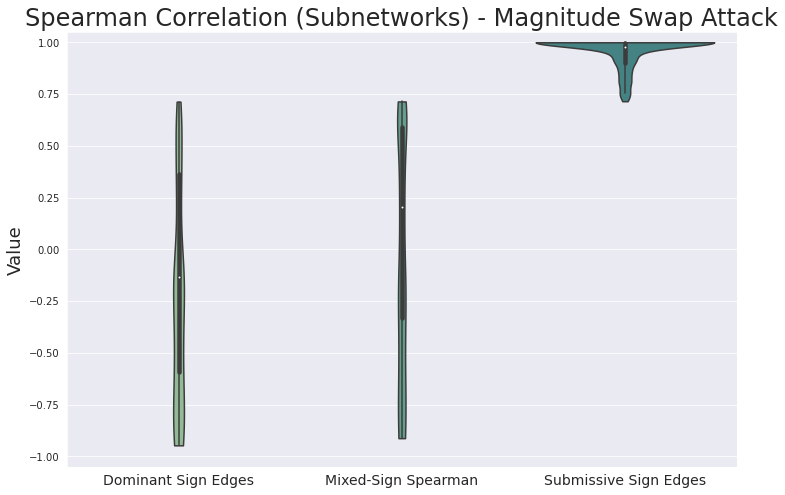

In [16]:
plot_attack_conv_comb(random_matrices, magnitude_attack, 'Spearman Correlation (Subnetworks) - Magnitude Swap Attack')

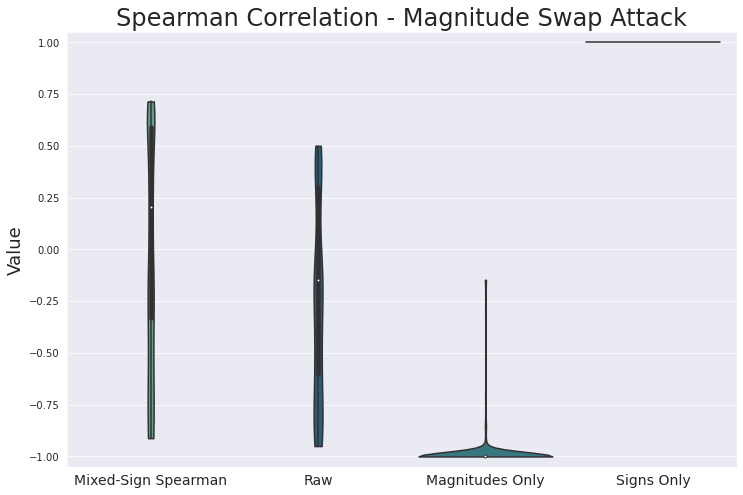

In [17]:
plot_attack_alts(random_matrices, magnitude_attack, 'Spearman Correlation - Magnitude Swap Attack')

## Sign Flip Attack

The raw spearman will be sensitive to this and report low scores. However, the magnitude spearman, only sensitive to magnitudes and oblivious to all else, will continue to report/give perfect scores after the attack.

In [18]:
def sign_attack(matrix):
    num_neg = np.sum(matrix < 0)
    num_pos = np.sum(matrix > 0)
    
    if num_neg > num_pos:
        result = np.where(matrix > 0, matrix, -matrix)
    if num_pos > num_neg:
        result = np.where(matrix < 0, matrix, -matrix)
        
    return result

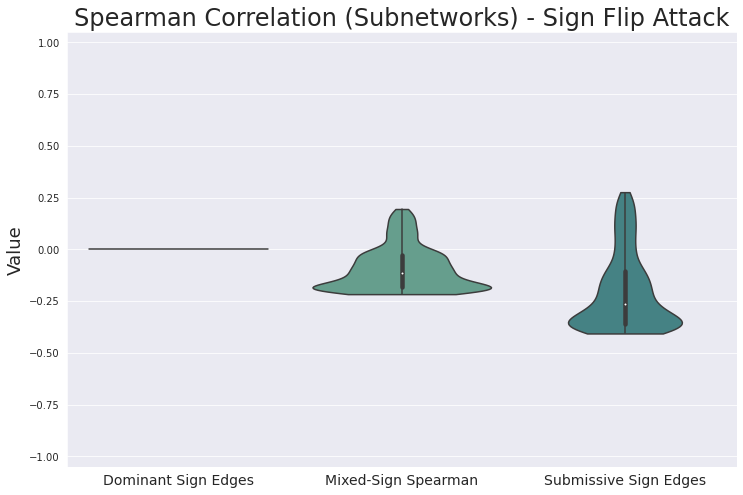

In [19]:
plot_attack_conv_comb(random_matrices, sign_attack, 'Spearman Correlation (Subnetworks) - Sign Flip Attack')

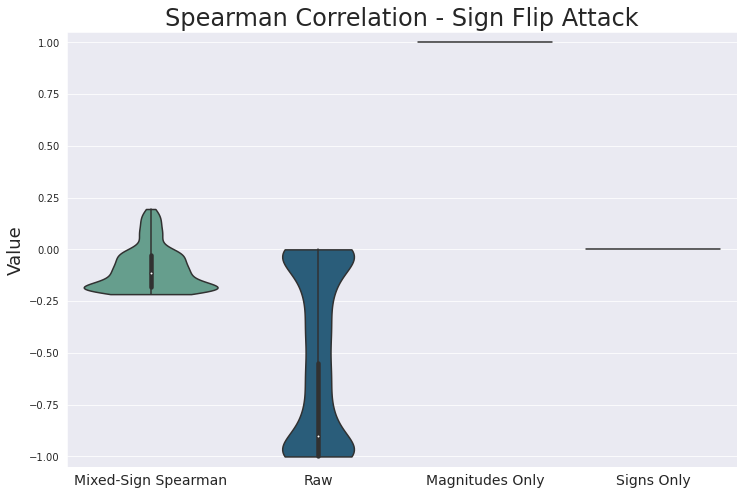

In [20]:
plot_attack_alts(random_matrices, sign_attack, 'Spearman Correlation - Sign Flip Attack')